# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

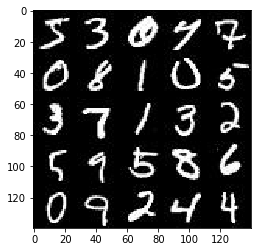

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

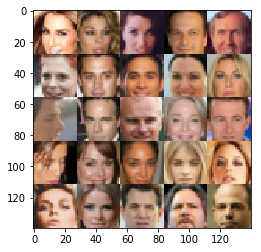

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    inputs_l = tf.placeholder(tf.float32, (None), name='input_l')

    return inputs_real, inputs_z, inputs_l


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(0.2 * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(0.2 * bn2, bn2)
        # 7x7x128

        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(0.2 * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not(is_train)):
        # First fully connected layer

        x1 = tf.layers.dense(z, 4*4*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(0.2 * x1, x1)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(0.2 * x2, x2)
        # 7x7x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(0.2 * x3, x3)
        # 14x14x128 now
        
        x4 = tf.layers.conv2d_transpose(x3, 64, 3, strides=2, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(0.2 * x4, x4)
        # 28x28x64 now
        
        x5 = tf.layers.conv2d_transpose(x4, 32, 3, strides=1, padding='same')
        x5 = tf.layers.batch_normalization(x5, training=is_train)
        x5 = tf.maximum(0.2 * x5, x5)
        # 28x28x32 now
        
        x6 = tf.layers.conv2d_transpose(x5, 32, 3, strides=1, padding='same')
        x6 = tf.layers.batch_normalization(x6, training=is_train)
        x6 = tf.maximum(0.2 * x6, x6)
        # 28x28x32 now
        
        x7 = tf.layers.conv2d_transpose(x6, 16, 1, strides=1, padding='same')
        x7 = tf.layers.batch_normalization(x7, training=is_train)
        x7 = tf.maximum(0.2 * x7, x7)
        # 28x28x16 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x7, out_channel_dim, 1, strides=1, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out  


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        # Get weights and bias to update
        t_vars = tf.trainable_variables()
        d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
        g_vars = [var for var in t_vars if var.name.startswith('generator')]

        # Optimize
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    # Create the network
    image_channels = out_channel_dim = data_shape[3]
    
    input_real, input_z, _ = model_inputs(data_shape[1], data_shape[2], image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    losses = []
    iteration = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                iteration += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})

                if iteration % 100 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))  
                    
                if iteration % 1000 == 0:
                    show_generator_output(sess, 25, input_z, out_channel_dim, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.7081... Generator Loss: 1.2072
Epoch 1/2... Discriminator Loss: 0.7179... Generator Loss: 1.2197
Epoch 1/2... Discriminator Loss: 1.2809... Generator Loss: 2.0654
Epoch 1/2... Discriminator Loss: 1.2238... Generator Loss: 0.5339
Epoch 1/2... Discriminator Loss: 0.9135... Generator Loss: 1.4668
Epoch 1/2... Discriminator Loss: 1.5382... Generator Loss: 2.0466
Epoch 1/2... Discriminator Loss: 0.9759... Generator Loss: 1.3269
Epoch 1/2... Discriminator Loss: 1.2657... Generator Loss: 1.5290
Epoch 1/2... Discriminator Loss: 1.4447... Generator Loss: 0.3521
Epoch 1/2... Discriminator Loss: 1.2734... Generator Loss: 0.9734


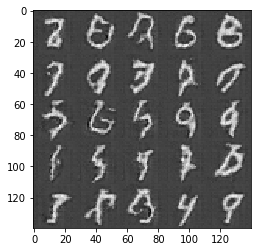

Epoch 1/2... Discriminator Loss: 1.1086... Generator Loss: 1.5271
Epoch 1/2... Discriminator Loss: 0.7912... Generator Loss: 1.3431
Epoch 1/2... Discriminator Loss: 1.0331... Generator Loss: 0.6994
Epoch 1/2... Discriminator Loss: 1.0157... Generator Loss: 0.9467
Epoch 1/2... Discriminator Loss: 0.9021... Generator Loss: 1.1469
Epoch 1/2... Discriminator Loss: 1.1212... Generator Loss: 0.7981
Epoch 1/2... Discriminator Loss: 0.8629... Generator Loss: 0.9399
Epoch 1/2... Discriminator Loss: 0.6673... Generator Loss: 1.0677
Epoch 1/2... Discriminator Loss: 1.0542... Generator Loss: 1.8146
Epoch 1/2... Discriminator Loss: 0.7209... Generator Loss: 1.2206


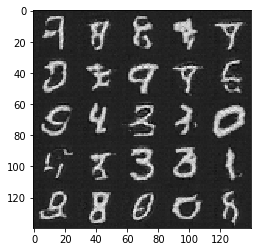

Epoch 1/2... Discriminator Loss: 0.9540... Generator Loss: 0.7484
Epoch 1/2... Discriminator Loss: 1.1828... Generator Loss: 0.5824
Epoch 1/2... Discriminator Loss: 0.8403... Generator Loss: 1.2183
Epoch 1/2... Discriminator Loss: 0.5411... Generator Loss: 1.4219
Epoch 1/2... Discriminator Loss: 0.7682... Generator Loss: 1.2031
Epoch 1/2... Discriminator Loss: 0.8889... Generator Loss: 0.9447
Epoch 1/2... Discriminator Loss: 1.2163... Generator Loss: 0.4962
Epoch 1/2... Discriminator Loss: 0.8996... Generator Loss: 1.0987
Epoch 1/2... Discriminator Loss: 0.9150... Generator Loss: 0.7412
Epoch 1/2... Discriminator Loss: 1.0901... Generator Loss: 0.7192


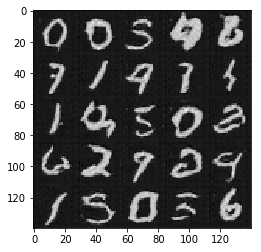

Epoch 1/2... Discriminator Loss: 1.1985... Generator Loss: 0.8308
Epoch 1/2... Discriminator Loss: 1.1383... Generator Loss: 0.9166
Epoch 1/2... Discriminator Loss: 0.8197... Generator Loss: 1.1070
Epoch 1/2... Discriminator Loss: 0.7978... Generator Loss: 0.9093
Epoch 1/2... Discriminator Loss: 0.7523... Generator Loss: 1.1960
Epoch 1/2... Discriminator Loss: 1.0935... Generator Loss: 0.5631
Epoch 1/2... Discriminator Loss: 1.1419... Generator Loss: 0.6108
Epoch 2/2... Discriminator Loss: 1.3199... Generator Loss: 0.4553
Epoch 2/2... Discriminator Loss: 0.7658... Generator Loss: 1.4510
Epoch 2/2... Discriminator Loss: 1.2360... Generator Loss: 0.7531


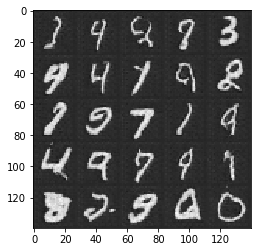

Epoch 2/2... Discriminator Loss: 1.0008... Generator Loss: 1.0737
Epoch 2/2... Discriminator Loss: 1.1467... Generator Loss: 0.8369
Epoch 2/2... Discriminator Loss: 1.5788... Generator Loss: 0.4076
Epoch 2/2... Discriminator Loss: 1.6184... Generator Loss: 0.5675
Epoch 2/2... Discriminator Loss: 0.8587... Generator Loss: 0.9930
Epoch 2/2... Discriminator Loss: 1.3069... Generator Loss: 0.5766
Epoch 2/2... Discriminator Loss: 0.7665... Generator Loss: 0.8809
Epoch 2/2... Discriminator Loss: 0.9666... Generator Loss: 0.9331
Epoch 2/2... Discriminator Loss: 1.1061... Generator Loss: 0.6606
Epoch 2/2... Discriminator Loss: 1.0429... Generator Loss: 1.0243


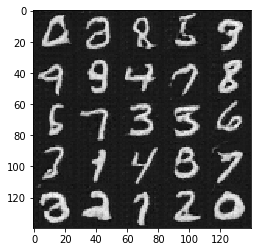

Epoch 2/2... Discriminator Loss: 1.4388... Generator Loss: 0.5411
Epoch 2/2... Discriminator Loss: 1.1118... Generator Loss: 0.7176
Epoch 2/2... Discriminator Loss: 1.2759... Generator Loss: 0.8409
Epoch 2/2... Discriminator Loss: 1.3887... Generator Loss: 0.5041
Epoch 2/2... Discriminator Loss: 1.2910... Generator Loss: 0.6134
Epoch 2/2... Discriminator Loss: 1.1763... Generator Loss: 0.6621
Epoch 2/2... Discriminator Loss: 1.0915... Generator Loss: 0.6825
Epoch 2/2... Discriminator Loss: 1.4875... Generator Loss: 0.7382
Epoch 2/2... Discriminator Loss: 0.9734... Generator Loss: 0.9504
Epoch 2/2... Discriminator Loss: 0.9709... Generator Loss: 0.9868


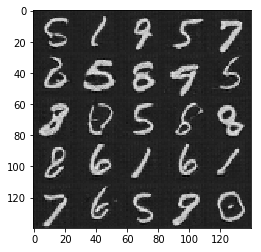

Epoch 2/2... Discriminator Loss: 0.8952... Generator Loss: 0.9910
Epoch 2/2... Discriminator Loss: 0.8515... Generator Loss: 0.9005
Epoch 2/2... Discriminator Loss: 0.9825... Generator Loss: 0.8948
Epoch 2/2... Discriminator Loss: 1.1496... Generator Loss: 0.6560
Epoch 2/2... Discriminator Loss: 1.1006... Generator Loss: 0.8341
Epoch 2/2... Discriminator Loss: 1.2272... Generator Loss: 0.5724
Epoch 2/2... Discriminator Loss: 0.9919... Generator Loss: 1.0516
Epoch 2/2... Discriminator Loss: 1.3137... Generator Loss: 0.6225
Epoch 2/2... Discriminator Loss: 1.1873... Generator Loss: 0.5656
Epoch 2/2... Discriminator Loss: 0.9223... Generator Loss: 0.7922


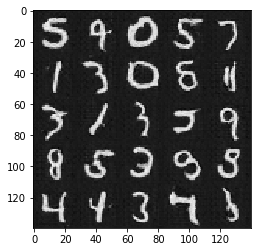

Epoch 2/2... Discriminator Loss: 0.8490... Generator Loss: 0.9480
Epoch 2/2... Discriminator Loss: 1.2249... Generator Loss: 0.5476
Epoch 2/2... Discriminator Loss: 1.0303... Generator Loss: 0.8500
Epoch 2/2... Discriminator Loss: 1.2781... Generator Loss: 0.7726
Epoch 2/2... Discriminator Loss: 0.9413... Generator Loss: 0.9197


In [12]:
batch_size = 16
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.1436... Generator Loss: 2.2893
Epoch 1/1... Discriminator Loss: 0.0009... Generator Loss: 8.0208
Epoch 1/1... Discriminator Loss: 0.6022... Generator Loss: 1.0434
Epoch 1/1... Discriminator Loss: 0.5259... Generator Loss: 1.5292
Epoch 1/1... Discriminator Loss: 0.6594... Generator Loss: 1.1530
Epoch 1/1... Discriminator Loss: 0.8893... Generator Loss: 0.9236
Epoch 1/1... Discriminator Loss: 1.8248... Generator Loss: 1.0052
Epoch 1/1... Discriminator Loss: 1.3022... Generator Loss: 2.9404
Epoch 1/1... Discriminator Loss: 1.5918... Generator Loss: 0.3772
Epoch 1/1... Discriminator Loss: 1.7346... Generator Loss: 1.5720


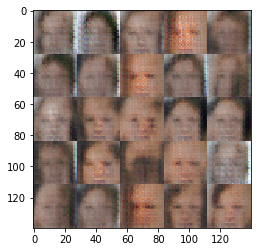

Epoch 1/1... Discriminator Loss: 1.5949... Generator Loss: 0.3057
Epoch 1/1... Discriminator Loss: 0.8944... Generator Loss: 0.7771
Epoch 1/1... Discriminator Loss: 1.1727... Generator Loss: 0.4879
Epoch 1/1... Discriminator Loss: 1.2118... Generator Loss: 0.8928
Epoch 1/1... Discriminator Loss: 1.0339... Generator Loss: 0.8025
Epoch 1/1... Discriminator Loss: 1.1178... Generator Loss: 1.1495
Epoch 1/1... Discriminator Loss: 0.9641... Generator Loss: 1.0082
Epoch 1/1... Discriminator Loss: 1.4056... Generator Loss: 0.8290
Epoch 1/1... Discriminator Loss: 1.3321... Generator Loss: 0.7616
Epoch 1/1... Discriminator Loss: 1.0372... Generator Loss: 0.6909


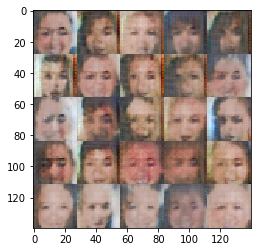

Epoch 1/1... Discriminator Loss: 1.2779... Generator Loss: 0.6022
Epoch 1/1... Discriminator Loss: 1.0842... Generator Loss: 0.6721
Epoch 1/1... Discriminator Loss: 1.5490... Generator Loss: 0.7779
Epoch 1/1... Discriminator Loss: 1.0644... Generator Loss: 0.7717
Epoch 1/1... Discriminator Loss: 1.4966... Generator Loss: 0.4433
Epoch 1/1... Discriminator Loss: 1.2871... Generator Loss: 0.8596
Epoch 1/1... Discriminator Loss: 1.1183... Generator Loss: 0.6490
Epoch 1/1... Discriminator Loss: 1.4735... Generator Loss: 0.5005
Epoch 1/1... Discriminator Loss: 1.1949... Generator Loss: 0.6882
Epoch 1/1... Discriminator Loss: 0.9681... Generator Loss: 0.8430


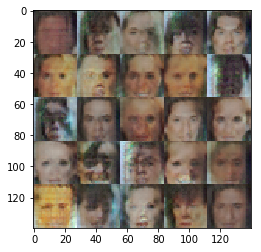

Epoch 1/1... Discriminator Loss: 1.2479... Generator Loss: 0.6347
Epoch 1/1... Discriminator Loss: 1.3735... Generator Loss: 0.5693
Epoch 1/1... Discriminator Loss: 1.1385... Generator Loss: 1.2165
Epoch 1/1... Discriminator Loss: 1.0479... Generator Loss: 0.7989
Epoch 1/1... Discriminator Loss: 1.5052... Generator Loss: 0.7341
Epoch 1/1... Discriminator Loss: 0.8738... Generator Loss: 1.1557
Epoch 1/1... Discriminator Loss: 1.1700... Generator Loss: 0.7294
Epoch 1/1... Discriminator Loss: 1.0477... Generator Loss: 0.7800
Epoch 1/1... Discriminator Loss: 1.0350... Generator Loss: 0.9393
Epoch 1/1... Discriminator Loss: 1.2263... Generator Loss: 0.6354


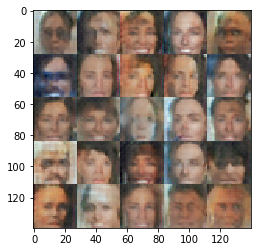

Epoch 1/1... Discriminator Loss: 0.9863... Generator Loss: 0.8387
Epoch 1/1... Discriminator Loss: 1.3028... Generator Loss: 0.5257
Epoch 1/1... Discriminator Loss: 1.0916... Generator Loss: 0.6697
Epoch 1/1... Discriminator Loss: 1.4323... Generator Loss: 0.4684
Epoch 1/1... Discriminator Loss: 1.4948... Generator Loss: 0.4742
Epoch 1/1... Discriminator Loss: 1.1039... Generator Loss: 0.7064
Epoch 1/1... Discriminator Loss: 1.1075... Generator Loss: 0.6732
Epoch 1/1... Discriminator Loss: 0.9669... Generator Loss: 0.8110
Epoch 1/1... Discriminator Loss: 1.4706... Generator Loss: 0.3573
Epoch 1/1... Discriminator Loss: 1.1613... Generator Loss: 0.9575


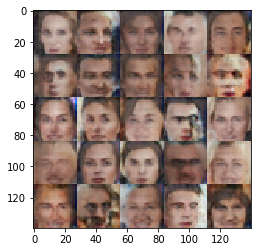

Epoch 1/1... Discriminator Loss: 1.2037... Generator Loss: 0.7347
Epoch 1/1... Discriminator Loss: 1.3621... Generator Loss: 0.4181
Epoch 1/1... Discriminator Loss: 1.4207... Generator Loss: 0.5411
Epoch 1/1... Discriminator Loss: 1.2019... Generator Loss: 0.6603
Epoch 1/1... Discriminator Loss: 1.1939... Generator Loss: 0.5576
Epoch 1/1... Discriminator Loss: 1.1884... Generator Loss: 0.6690
Epoch 1/1... Discriminator Loss: 1.0873... Generator Loss: 0.7221
Epoch 1/1... Discriminator Loss: 1.1422... Generator Loss: 0.7544
Epoch 1/1... Discriminator Loss: 1.1820... Generator Loss: 0.6352
Epoch 1/1... Discriminator Loss: 1.4042... Generator Loss: 0.6105


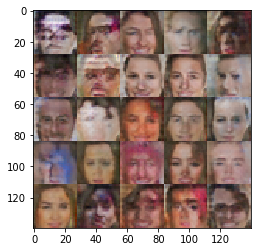

Epoch 1/1... Discriminator Loss: 0.9607... Generator Loss: 1.0295
Epoch 1/1... Discriminator Loss: 1.4627... Generator Loss: 0.4419
Epoch 1/1... Discriminator Loss: 1.3227... Generator Loss: 0.5249
Epoch 1/1... Discriminator Loss: 1.2397... Generator Loss: 0.5727
Epoch 1/1... Discriminator Loss: 1.0257... Generator Loss: 0.8535
Epoch 1/1... Discriminator Loss: 1.3614... Generator Loss: 0.6599
Epoch 1/1... Discriminator Loss: 1.2460... Generator Loss: 0.5569
Epoch 1/1... Discriminator Loss: 1.1263... Generator Loss: 0.8056
Epoch 1/1... Discriminator Loss: 1.3635... Generator Loss: 0.6636
Epoch 1/1... Discriminator Loss: 1.1308... Generator Loss: 0.7553


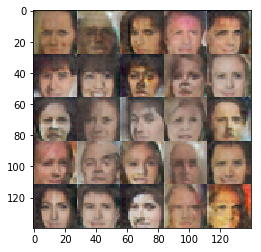

Epoch 1/1... Discriminator Loss: 1.2138... Generator Loss: 0.5994
Epoch 1/1... Discriminator Loss: 1.3140... Generator Loss: 0.6229
Epoch 1/1... Discriminator Loss: 1.1641... Generator Loss: 0.7413
Epoch 1/1... Discriminator Loss: 1.1819... Generator Loss: 0.7719
Epoch 1/1... Discriminator Loss: 1.2537... Generator Loss: 0.7009
Epoch 1/1... Discriminator Loss: 1.2354... Generator Loss: 0.6715
Epoch 1/1... Discriminator Loss: 1.2444... Generator Loss: 0.6360
Epoch 1/1... Discriminator Loss: 1.2535... Generator Loss: 0.7122
Epoch 1/1... Discriminator Loss: 1.3541... Generator Loss: 0.7596
Epoch 1/1... Discriminator Loss: 1.1874... Generator Loss: 0.7842


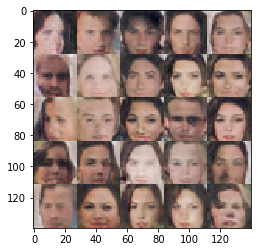

Epoch 1/1... Discriminator Loss: 1.2626... Generator Loss: 1.0152
Epoch 1/1... Discriminator Loss: 1.3704... Generator Loss: 0.4854
Epoch 1/1... Discriminator Loss: 1.2875... Generator Loss: 0.7031
Epoch 1/1... Discriminator Loss: 0.9906... Generator Loss: 1.1314
Epoch 1/1... Discriminator Loss: 1.2732... Generator Loss: 0.8074
Epoch 1/1... Discriminator Loss: 1.1595... Generator Loss: 0.8148
Epoch 1/1... Discriminator Loss: 1.2487... Generator Loss: 0.6910
Epoch 1/1... Discriminator Loss: 1.2405... Generator Loss: 0.6711
Epoch 1/1... Discriminator Loss: 1.0530... Generator Loss: 0.8709
Epoch 1/1... Discriminator Loss: 1.4512... Generator Loss: 0.5159


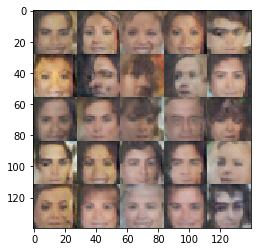

Epoch 1/1... Discriminator Loss: 1.2425... Generator Loss: 0.7773
Epoch 1/1... Discriminator Loss: 1.2622... Generator Loss: 0.7219
Epoch 1/1... Discriminator Loss: 1.1766... Generator Loss: 0.6939
Epoch 1/1... Discriminator Loss: 1.2120... Generator Loss: 0.7742
Epoch 1/1... Discriminator Loss: 1.3080... Generator Loss: 0.6051
Epoch 1/1... Discriminator Loss: 1.4667... Generator Loss: 0.5633
Epoch 1/1... Discriminator Loss: 1.3147... Generator Loss: 0.5078
Epoch 1/1... Discriminator Loss: 1.2678... Generator Loss: 0.7559
Epoch 1/1... Discriminator Loss: 1.5382... Generator Loss: 0.6390
Epoch 1/1... Discriminator Loss: 1.0248... Generator Loss: 1.0642


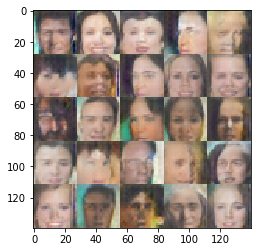

Epoch 1/1... Discriminator Loss: 1.3153... Generator Loss: 0.7593
Epoch 1/1... Discriminator Loss: 1.2980... Generator Loss: 0.6840
Epoch 1/1... Discriminator Loss: 1.2850... Generator Loss: 0.7184
Epoch 1/1... Discriminator Loss: 1.3530... Generator Loss: 0.6883
Epoch 1/1... Discriminator Loss: 1.0470... Generator Loss: 0.9017
Epoch 1/1... Discriminator Loss: 1.3763... Generator Loss: 0.5316
Epoch 1/1... Discriminator Loss: 1.3218... Generator Loss: 0.6631
Epoch 1/1... Discriminator Loss: 1.4221... Generator Loss: 0.7157
Epoch 1/1... Discriminator Loss: 1.2686... Generator Loss: 0.7331
Epoch 1/1... Discriminator Loss: 1.2121... Generator Loss: 0.6712


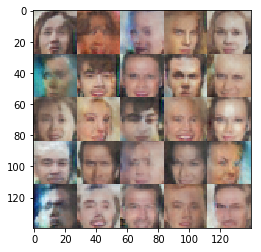

Epoch 1/1... Discriminator Loss: 1.2699... Generator Loss: 0.6496
Epoch 1/1... Discriminator Loss: 1.1856... Generator Loss: 0.8057
Epoch 1/1... Discriminator Loss: 1.4158... Generator Loss: 0.6989
Epoch 1/1... Discriminator Loss: 1.3234... Generator Loss: 0.6217
Epoch 1/1... Discriminator Loss: 1.3625... Generator Loss: 0.7033
Epoch 1/1... Discriminator Loss: 1.3536... Generator Loss: 0.6377
Epoch 1/1... Discriminator Loss: 1.3605... Generator Loss: 0.6670
Epoch 1/1... Discriminator Loss: 1.4710... Generator Loss: 0.5990
Epoch 1/1... Discriminator Loss: 1.3016... Generator Loss: 0.6531
Epoch 1/1... Discriminator Loss: 1.3731... Generator Loss: 0.5886


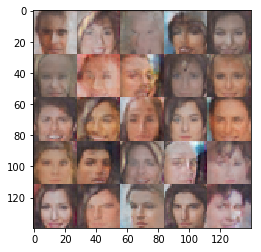

Epoch 1/1... Discriminator Loss: 1.2675... Generator Loss: 0.7417
Epoch 1/1... Discriminator Loss: 1.2791... Generator Loss: 0.7253
Epoch 1/1... Discriminator Loss: 1.3030... Generator Loss: 0.6795
Epoch 1/1... Discriminator Loss: 1.1346... Generator Loss: 0.7315
Epoch 1/1... Discriminator Loss: 1.2149... Generator Loss: 0.7560
Epoch 1/1... Discriminator Loss: 1.4699... Generator Loss: 0.6156


In [13]:
batch_size = 16
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.